# Community detection - Stochastic block model

Original data: from the `painter_networks.ipynb` notebook

## Imports, initial procedures

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import ast #simple string to list/dict methods

from data_processing import process
from data_processing import plot
from data_processing import measures

#Dataset of painters/artists:
artists = pd.read_csv("data/artists.csv").drop(columns=["Type", "Contemporary"])#Type and contemporary are artificial columns

In [2]:
from graph_tool.all import *

In [ ]:
#Load the graph from the graphml file
g = load_graph("data/graph.graphml")

In [5]:
g = Graph(directed=False)

#Edgeweight property
weight = g.new_edge_property("double")

#Artist-vertex dictionary + property
vertex_dict = {}
artist_name = g.new_vertex_property("string")

for artist in artists['artist']:
    v = g.add_vertex()
    vertex_dict[artist] = v
    artist_name[v] = artist

for artist1, artist2 in itertools.combinations(artists['artist'], 2):
    artist1_data = artist_data[artist1]
    artist2_data = artist_data[artist2]
    
    years1 = years[artist1]
    years2 = years[artist2]
    if type(years1) != list or type(years2) != list: #np.nan
        continue

    birthplace1 = artist1_data["birth_place"]
    birthplace2 = artist2_data["birth_place"]
    
    nationalities1 = nationalities[artist1]
    nationalities2 = nationalities[artist2]
    
    citizenship1 = artist1_data['citizenship']
    citizenship2 = artist2_data['citizenship']
    
    places1_list = places[artist1]
    places2_list = places[artist2]
    
    index_val = process.get_loc_similarity(places1_list, places2_list, years1, years2, birthplace1, birthplace2, 
                                                nationalities1, nationalities2, citizenship1, citizenship2, active_years_only=True)
    
    if (index_val > 0):
        e = g.add_edge(vertex_dict[artist1], vertex_dict[artist2])
        weight[e] = index_val

#Save property map
g.edge_properties["weight"] = weight
g.vertex_properties["artist_name"] = artist_name

## Community detection

To find communiti

In [71]:
state = minimize_nested_blockmodel_dl(g_biggest_component, state_args=dict(recs=[g_biggest_component.ep.weight], rec_types=["real-exponential"]))

In [72]:
state.levels[0]

<BlockState object with 2959 blocks (85 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, undirected, with 2959 vertices and 65374 edges, 1 internal vertex property, 1 internal edge property, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7e8b2650d8d0, at 0x7e8b2569b110>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7e8b2650d8d0, at 0x7e8b256109d0>, False), at 0x7e8b2650d8d0>, at 0x7e8df1b96210>

We have 85 communities of the 3000 artists, which we will further analyze. Before that, it's interesting how they are connected:

**NOTE**: Output was removed to save memory, I saved it in the image subfolder as a .png

In [94]:
state.draw(edge_color=prop_to_size(g_biggest_component.ep.weight, power=1, log=True),
           eorder=g_biggest_component.ep.weight, # edge ordering is important!
           edge_pen_width=2,
          output = "image/painters_nested_blockmodel.png");



(*Note during the presentation*: -Toma: There is one small community very much interconnected, might be interesting to look at.<br>
-Tiago: Probably coloring nodes and not edges would have been more meaningful.)

## Observations from communities

We look into communities:

In [ ]:
# Create a look up table of block ids and included artist names
block_to_artist = {}
for v in g_biggest_component.vertices():
    block_id = b[v]
    artist = g_biggest_component.vertex_properties['artist_name'][v]
    if block_id not in block_to_artist:
        block_to_artist[block_id] = [] # Create the list, put the artist in it below
    block_to_artist[block_id].append(artist)

Let's see the global trends in the dataset first:

In [135]:
process.get_column_counts_adjusted(artists, 'Nationality')[0:3], process.get_column_counts_adjusted(artists, 'citizenship')[0:3]

(Nationality
 American    0.149137
 French      0.094495
 British     0.081758
 Name: proportion, dtype: float64,
 citizenship
 United States of America    0.150207
 France                      0.132678
 Spain                       0.043608
 Name: proportion, dtype: float64)

In [88]:
process.get_female_percentage(artists), process.get_column_average(artists, 'birth_year'), process.get_column_average(artists, 'wikiart_pictures_count')

(11.73601433406331, 1818.2762943334692, 54.729940680611925)

Now let's build a dataframe of averages, counts from blocks (functions included in the data_processing module):

In [102]:
blocks_nationality = []; blocks_citizenship = []; blocks_gender = []; blocks_birth_year = []; blocks_wikiart_pictures_count = []; blocks_styles = []; blocks_movement = []; blocks_size = []
for block_id, artists_in_block in block_to_artist.items():
    artists_in_block_df = artists[artists['artist'].isin(artists_in_block)]
    blocks_nationality.append(process.get_column_counts_adjusted(artists_in_block_df, 'Nationality'))
    blocks_citizenship.append(process.get_column_counts_adjusted(artists_in_block_df, 'citizenship'))
    blocks_gender.append(process.get_female_percentage(artists_in_block_df))
    blocks_birth_year.append(process.get_column_average(artists_in_block_df, 'birth_year'))
    blocks_wikiart_pictures_count.append(process.get_column_average(artists_in_block_df, 'wikiart_pictures_count'))
    blocks_styles.append(process.get_column_counts_adjusted(artists_in_block_df, 'styles'))
    blocks_movement.append(process.get_column_counts_adjusted(artists_in_block_df, 'movement'))
    #Add amount of artists in block to the dataframe
    blocks_size.append(len(artists_in_block))
#DF
block_data = pd.DataFrame({'Size':blocks_size, 'Nationality': blocks_nationality, 'citizenship': blocks_citizenship, 'gender': blocks_gender, 'birth_year': blocks_birth_year, 'wikiart_pictures_count': blocks_wikiart_pictures_count, 'styles': blocks_styles, 'movement': blocks_movement})


In [103]:
block_data.sort_values(by='birth_year', ascending=True)

,Size,Nationality,citizenship,gender,birth_year,wikiart_pictures_count,styles,movement
76,41,Nationality Italian 0.764706 Flemish 0.2...,citizenship Republic of Florence 0.409091...,0.000000,1413.675000,59.000000,"styles Early Renaissance, Unknown ...",movement Early Renaissance 0.736842 Nort...
81,30,Nationality German 0.666667 Dutch 0.333...,citizenship Germany 0.296...,0.000000,1505.266667,95.600000,"styles Northern Renaissance, Unknown ...",movement Northern Renaissance 1.0 Name: pro...
67,17,"Nationality Flemish 1.0 Name: proportion, d...",citizenship Habsburg Netherlands 0.3750 Net...,0.000000,1556.411765,47.500000,styles Baroque ...,"movement Baroque 1.0 Name: proportion, dtyp..."
75,70,Nationality Italian 0.814815 Fle...,citizenship Republic of Venice 0.44 Rep...,0.000000,1564.042857,106.259259,styles High Renaissance ...,movement High Renaissance 0.666667 Nort...
24,51,Nationality Italian 0.642857 Fre...,citizenship Republic of Venice 0.16...,7.843137,1573.019608,49.187500,"styles Baroque, Unknown 0.250...",movement Baroque 0.9375 Northe...
...,...,...,...,...,...,...,...,...
31,54,Nationality American 0.952381 Ame...,citizenship United States of America 0.9811...,26.415094,1931.629630,33.152174,styles Minimalism ...,movement Abstract Expressionism 0.13043...
27,61,Nationality British 0.55...,citizenship United Kingdom ...,14.754098,1934.114754,38.170213,styles Post-Minimalism ...,movement Abstract Expressionism 0.127...
45,16,Nationality American 0.857143 Leba...,citizenship United States of America 1.0 Na...,18.750000,1935.750000,26.916667,styles Minimalism ...,movement Conceptual Art 0.25000...
44,57,Nationality American 0.681818 ...,citizenship United States of America 0.7551...,17.543860,1938.035088,27.386364,styles Conceptual Art ...,movement Conceptual Art ...


We can see that the artists inside groups share nationality very much. What can we say about comparable differences between communities? Do they differ much? 

### Gender representation

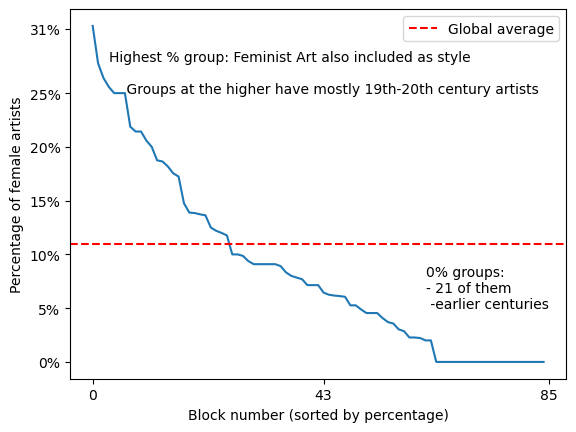

In [170]:
import matplotlib.pyplot as plt

plt.plot(block_data['gender'].sort_values(ascending=False).values)
plt.ylabel('Percentage of female artists')
plt.xlabel('Block number (sorted by percentage)')
#Add ticks, with percentages
plt.xticks([0, 43, 85])
plt.yticks([0,5,10,15,20,25,31], ["0%","5%","10%","15%","20%","25%","31%"])
plt.axhline(y=11, color='r', linestyle='--', label = 'Global average')
plt.legend()
plt.text(3, 25, 'Highest % group: Feminist Art also included as style\n\n    Groups at the higher have mostly 19th-20th century artists');
plt.text(62, 5, '0% groups:\n- 21 of them\n -earlier centuries');

Looking more into it, seems like lower percentages seem to come from earlier centuries.

Let's try to "prove" that:

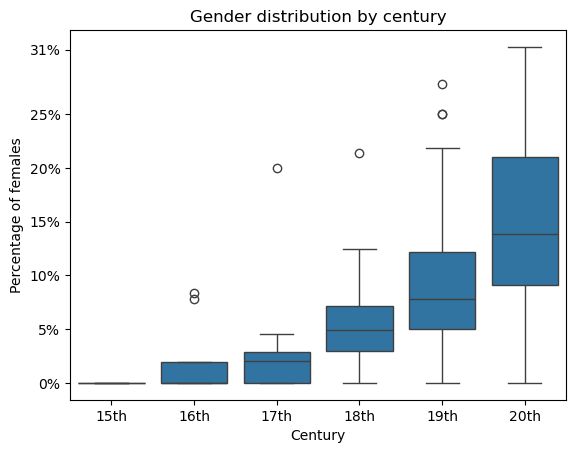

In [169]:
import seaborn as sns
import numpy as np

#Simplify to centuries
block_data['century'] = (block_data['birth_year'] // 100 + 1).astype(int)

# Create a boxplot
sns.boxplot(x='century', y='gender', data=block_data)

# Set plot labels
plt.xlabel('Century')
plt.ylabel('Percentage of females')
plt.title('Gender distribution by century')

# Set x-axis ticks
plt.xticks(np.arange(0, 6), ['15th', '16th', '17th', '18th', '19th', '20th'])
plt.yticks([0,5,10,15,20,25,31], ["0%","5%","10%","15%","20%","25%","31%"])

plt.show()

Indeed, we see this upward going trend.

### WikiArt pictures count: average per artist, plotted for all communities

This is a not bad measure of success, at least for 19th-20th century artists. (Older centuries have less paintings reserved.)

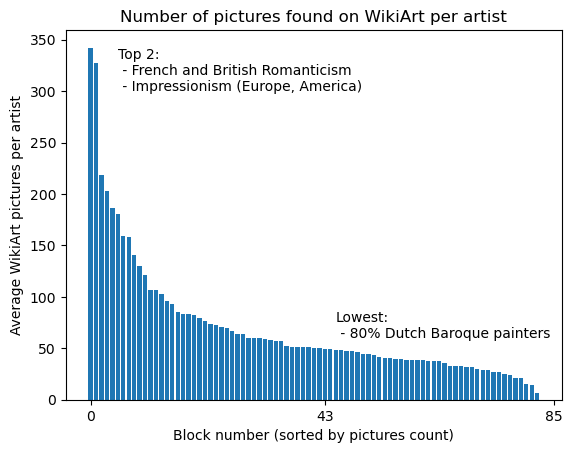

In [173]:
#Plot wikiart pictures count
plt.bar(range(len(block_data['wikiart_pictures_count'])), block_data['wikiart_pictures_count'].sort_values(ascending=False).values)
plt.ylabel('Average WikiArt pictures per artist')
plt.xlabel('Block number (sorted by pictures count)')
plt.xticks([0, 43, 85])
plt.text(5, 300, 'Top 2:\n - French and British Romanticism\n - Impressionism (Europe, America)',);
plt.text(45, 60, 'Lowest:\n - 80% Dutch Baroque painters ',);
plt.title("Number of pictures found on WikiArt per artist");
